# Paper: Towards JITAI: 

This notebook shows the analysis of situational context using EMA and passive sensing data

1. **Load Data**: Load necessary data from pickle files.
2. **Preprocess EMA**:
- Keep only first assessment phase 
- Remove all entries that have no complete EMA assessment 
- Remove all participants with too few data 
- Create blocks of assessment 
3. **Perform Item Analysis according to Siepe et al. (2022)**

In [1]:
import os
import sys
import regex as re
# If your current working directory is the notebooks directory, use this:
notebook_dir = os.getcwd()  # current working directory
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
import glob
import pickle
from IPython.display import Markdown
from server_config import datapath, preprocessed_path

import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import entropy

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [2]:
# Plotting
# Original colors for situation categories mapped to the simplified names
situation_colors = {
    'other': '#1f77b4',
    'care work': '#ff7f0e',
    'travelling': '#2ca02c',
    'chores': '#d62728',
    'eating - drinking - selfcare': '#9467bd',  # Updated name to match the new mapping
    'active leisure': '#8c564b',
    'smartphone - social media': '#e377c2',  # Updated name to match the new mapping
    'passive leisure': '#7f7f7f',
    'work or study': '#bcbd22'
}


# Paired colors for diagnosis categories
diagnosis_colors = {
    'Depressive Disorder': '#a6cee3',   # Light Blue
    'Social Anxiety Disorder': '#1f78b4',  # Dark Blue
    'Obsessive-Compulsive Disorder': '#b2df8a',  # Light Green
    'Generalized Anxiety Disorder': '#33a02c',  # Dark Green
    'Agoraphobia and/or Panic Disorder': '#fb9a99',  # Light Pink
    'Post-Traumatic Stress Disorder': '#e31a1c',  # Red
    'Specific Phobia': '#fdbf6f'}





In [3]:
# Plotting

# Function to get color for situation category
def get_situation_color(category):
    return situation_colors.get(category, '#000000')  # Default to black if category not found

# Function to get color for diagnosis category
def get_diagnosis_color(category):
    return diagnosis_colors.get(category, '#000000')  # Default to black if category not found


In [4]:
#backup_path = preprocessed_path + "backup_data_passive.feather"
#df_backup = pd.read_feather(backup_path)

with open(preprocessed_path + '/ema_data.pkl', 'rb') as file:
    df_ema_framework = pickle.load(file)

with open(preprocessed_path + '/ema_content.pkl', 'rb') as file:
    df_ema_content = pickle.load(file)  

with open(preprocessed_path + '/monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

with open(preprocessed_path + '/redcap_data.pkl', 'rb') as file:
    df_redcap = pickle.load(file)

with open(preprocessed_path + '/map_ema_passive.pkl', 'rb') as file:
    df_ema_passive = pickle.load(file)

In [5]:
df_ema_passive

,customer,createdAt_day,unique_day_id,assess,sensor_block_end,sensor_block_start,n_steps,n_GPS,total_distance_km,transition,transition_minutes,at_home_minute,at_home_binary
0,MYAi,2023-09-19,20230919_1,0,2023-09-19 07:31:20.352,2023-09-19 05:31:20.352,295,115,0.445619,0,0.000000,118.0,1
32,MYAi,2023-09-19,20230919_6,0,2023-09-19 17:14:33.463,2023-09-19 15:14:33.463,11126,286,16.757672,1,18.750000,0.0,0
33,MYAi,2023-09-28,20230928_6,0,2023-09-28 18:29:55.737,2023-09-28 16:29:55.737,12097,2,19.321239,1,35.283333,0.0,0
35,MYAi,2023-09-25,20230925_6,0,2023-09-25 17:08:34.592,2023-09-25 15:08:34.592,13281,0,0.000000,-1,0.000000,0.0,-1
39,MYAi,2023-09-22,20230922_6,0,2023-09-22 17:06:14.166,2023-09-22 15:06:14.166,6328,85,6.815990,1,12.200000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
760451,xwB7,2023-07-21,20230721_4,0,2023-07-21 11:40:30.657,2023-07-21 09:40:30.657,4374,0,0.000000,-1,0.000000,0.0,-1
760480,xwB7,2023-07-20,20230720_5,0,2023-07-20 13:46:15.775,2023-07-20 11:46:15.775,6063,0,0.000000,-1,0.000000,0.0,-1
760510,xwB7,2023-07-20,20230720_7,0,2023-07-20 16:58:19.651,2023-07-20 14:58:19.651,4497,0,0.000000,-1,0.000000,0.0,-1
760544,tpJ1,2024-09-03,20240903_2,0,2024-09-03 10:17:33.582,2024-09-03 08:17:33.582,3190,0,0.000000,-1,0.000000,0.0,-1


### Configurations

In [6]:
# EMA
assessment_phase = [0] #1,2
min_num_daily = 4
min_days_data = 7



### 1. Include only patients with finished assessments and enough quests

In [7]:
# first assessment phase finished
df_ema = df_ema_content.loc[df_ema_content.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2", "Erhebung_3_aktiv", "Dropout"])]

In [8]:
df_ema1 = df_ema.loc[df_ema.study.isin([24,25])] # first assessment phase
df_ema2 = df_ema.loc[df_ema.study.isin([33,34])] # second assessment phase
df_ema3 = df_ema.loc[df_ema.study.isin([33,34])] # third assessment phase

In [9]:
df_ema1 = df_ema1.loc[df_ema1["n_quest"] >= min_num_daily]
df_ema1["n_days_min"] = df_ema1.groupby("customer")['quest_complete_day'].transform("nunique")
df_ema1 = df_ema1.loc[df_ema1.n_days_min >= min_days_data]
df_ema1_customers = df_ema1.customer.unique().tolist()

In [10]:
df_ema2 = df_ema2.loc[df_ema2["n_quest"] >= min_num_daily]
df_ema2["n_days_min"] = df_ema2.groupby("customer")['quest_complete_day'].transform("nunique")
df_ema2 = df_ema2.loc[df_ema2.n_days_min >= min_days_data]
df_ema2_customers = df_ema2.customer.unique().tolist()

In [11]:
df_ema3 = df_ema3.loc[df_ema3["n_quest"] >= min_num_daily]
df_ema3["n_days_min"] = df_ema3.groupby("customer")['quest_complete_day'].transform("nunique")
df_ema3 = df_ema3.loc[df_ema3.n_days_min >= min_days_data]
df_ema3_customers = df_ema3.customer.unique().tolist()

### 2. Pivot table to get assessments merged together

In [12]:
df_social = df_ema[df_ema.quest_title == "event_social2"]

In [13]:
df_sit = df_ema[df_ema.quest_title =="situation1"]

In [14]:
df_nosit = df_ema[(df_ema['quest_title'] != 'event_social2') & (df_ema['quest_title'] != 'situation1')]


In [15]:
# Pivot the table as specified
df_sit = df_sit.pivot_table(
    index=["customer", "unique_day_id", "quest_create", "choice_id"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_sit.columns = [col for col in df_sit.columns.values]

# Reset the index to turn the MultiIndex into columns
df_sit = df_sit.reset_index()

df_sit = df_sit.drop_duplicates(subset=['customer', 'unique_day_id', 'choice_id'])


df_sit['situation_count'] = df_sit.groupby(["customer","unique_day_id"])["choice_id"].transform('count')

In [16]:
# Pivot the table as specified
df_social = df_social.pivot_table(
    index=["customer", "unique_day_id", "choice_id"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_social.columns = [col for col in df_social.columns.values]

# Reset the index to turn the MultiIndex into columns
df_social = df_social.reset_index()
df_sit = df_sit.drop_duplicates(subset=['customer', 'unique_day_id', 'choice_id'])

df_social['social_contact_count'] = df_social.groupby(["customer","unique_day_id"])["choice_id"].transform('count')

In [17]:
df_social = df_social.drop(columns=['choice_id'])

In [18]:
# Pivot the table as specified
df_piv = df_nosit.pivot_table(
    index=["customer", "unique_day_id", "assess", "quest_complete_day", "absolute_day_index", "relative_day_index", "weekend", "quest_nr", "weekday"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_piv.columns = [col for col in df_piv.columns.values]

# Reset the index to turn the MultiIndex into columns
df_piv = df_piv.reset_index()
df_piv = df_piv.drop_duplicates()


In [19]:

pa_scale = ['panas_attentiveness', 'panas_joviality1', 'panas_joviality2', 
            'panas_selfassurance', 'panas_serenity1', 'panas_serenity2']
na_scale = ['panas_fear1', 'panas_fear2', 'panas_guilt1', 
            'panas_guilt2', 'panas_hostility1', 'panas_hostility2', 
             'panas_sadness1', 'panas_sadness2', 'panas_loneliness']

# Step 1: Ensure the columns in pa_scale and na_scale are numeric
df_piv[pa_scale + na_scale] = df_piv[pa_scale + na_scale].apply(pd.to_numeric, errors='coerce')

# Step 2: Calculate the mean for PA and NA scales per unique_day_id
df_piv['mean_pa'] = df_piv.groupby(['customer', 'unique_day_id'])[pa_scale].transform('mean').mean(axis=1)
df_piv['mean_na'] = df_piv.groupby(['customer', 'unique_day_id'])[na_scale].transform('mean').mean(axis=1)


In [20]:
# Calculate the variance of each NA subscale per individual
individual_variance = df_piv.groupby('customer')[na_scale].var()
# Aggregate variance across individuals (mean variance for each subscale)
average_variance_per_subscale = individual_variance.mean()

# Display the average variance per subscale
print(average_variance_per_subscale)

panas_fear1         1.401390
panas_fear2         1.630749
panas_guilt1        1.276730
panas_guilt2        1.784037
panas_hostility1    1.629005
panas_hostility2    1.346876
panas_sadness1      1.711182
panas_sadness2      1.599512
panas_loneliness    1.572446
dtype: float64


In [45]:
df_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28568 entries, 0 to 28567
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer             28568 non-null  object        
 1   unique_day_id        28568 non-null  object        
 2   assess               28568 non-null  int64         
 3   quest_complete_day   28568 non-null  datetime64[ns]
 4   absolute_day_index   28568 non-null  int64         
 5   relative_day_index   28568 non-null  int64         
 6   weekend              28568 non-null  int64         
 7   quest_nr             28568 non-null  float64       
 8   weekday              28568 non-null  object        
 9   ecg_control          7493 non-null   object        
 10  er_acceptance        28456 non-null  object        
 11  er_control           28462 non-null  object        
 12  er_distraction       28460 non-null  object        
 13  er_intensity         28471 non-

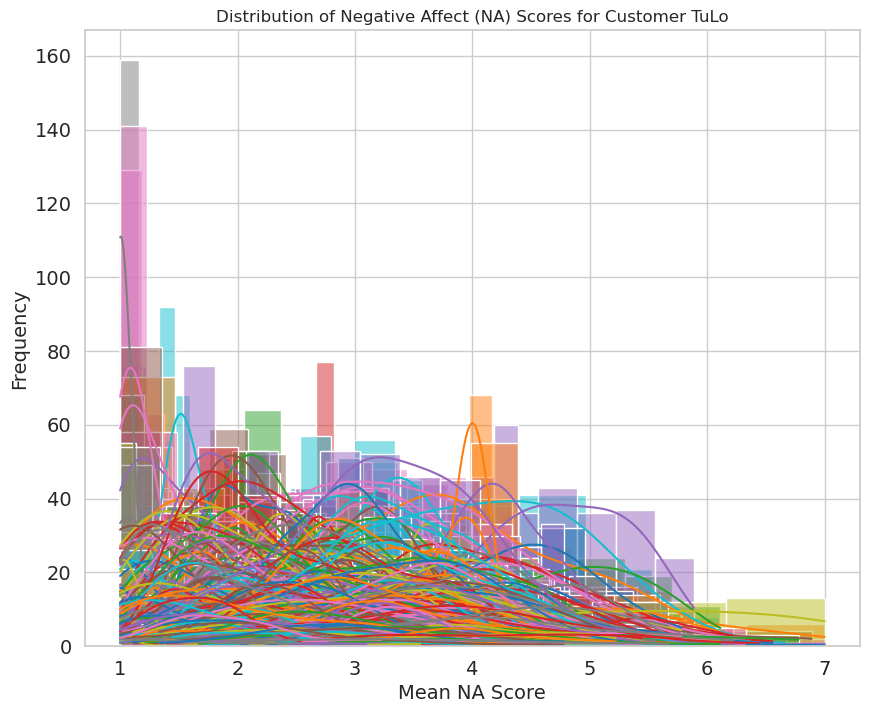

In [46]:

# Assuming 'df_piv' contains customer data and 'customer_id' is the column for customer IDs
# Adjust this to match the actual column names and structure of your dataset.

# Get a list of the first 50 unique customers
unique_customers = df_piv['customer'].sample(n=10000).unique()

f, ax = plt.subplots(figsize=(10, 8))
# Loop through each customer and create a plot
for customer in unique_customers:
    # Filter data for the current customer
    customer_data = df_piv[df_piv['customer'] == customer]

    # Create the distribution plot for 'mean_na'
    sns.histplot(customer_data['mean_na'], kde=True, ax=ax)
    plt.title(f'Distribution of Negative Affect (NA) Scores for Customer {customer}')
    plt.xlabel('Mean NA Score')
    plt.ylabel('Frequency')

    # Show the plot
plt.show()


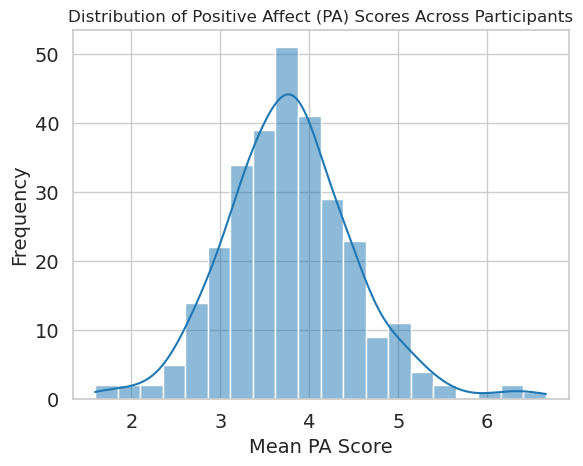

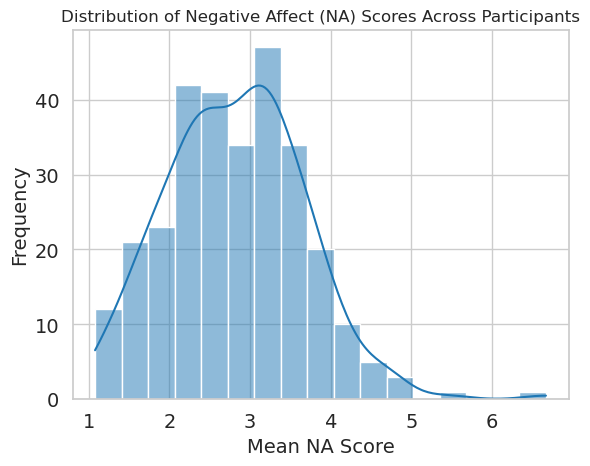

In [22]:
# Aggregate PA and NA means at the participant level
participant_means = df_piv.groupby('customer')[['mean_pa', 'mean_na']].mean()

# Plotting the distribution of mean PA scores across participants
sns.histplot(participant_means['mean_pa'], kde=True)
plt.title('Distribution of Positive Affect (PA) Scores Across Participants')
plt.xlabel('Mean PA Score')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of mean NA scores across participants
sns.histplot(participant_means['mean_na'], kde=True)
plt.title('Distribution of Negative Affect (NA) Scores Across Participants')
plt.xlabel('Mean NA Score')
plt.ylabel('Frequency')
plt.show()


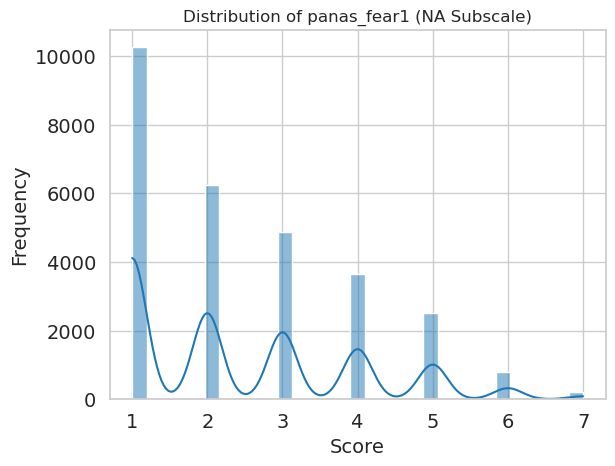

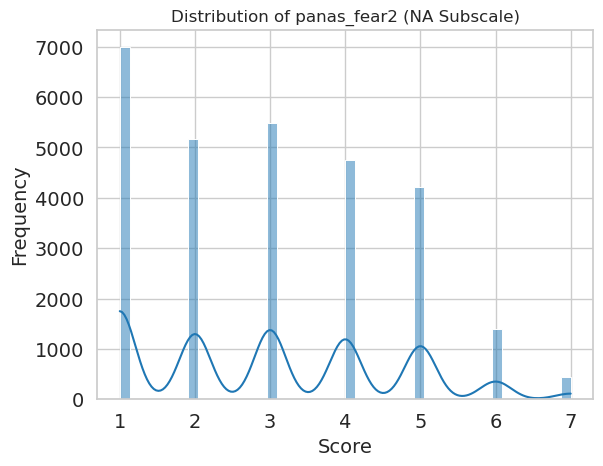

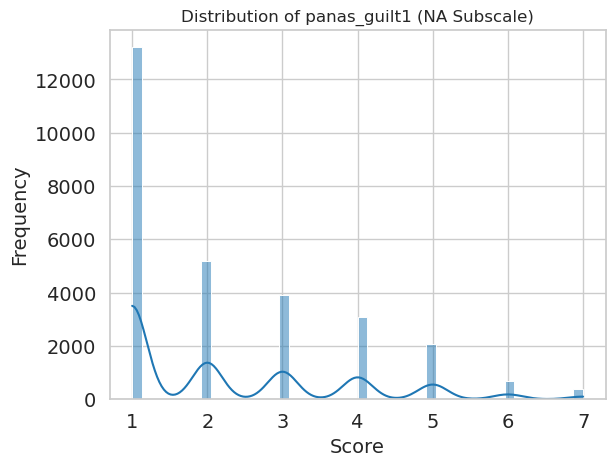

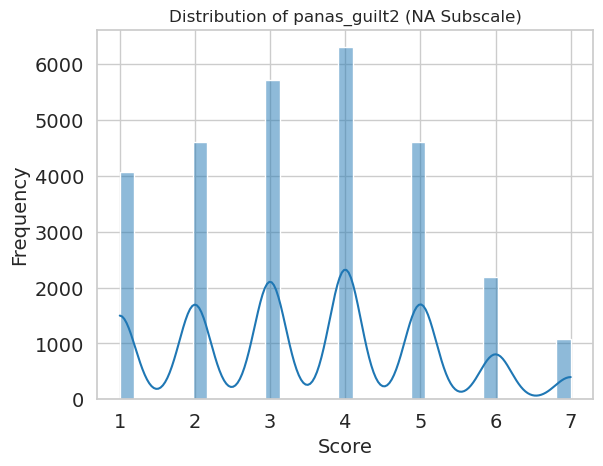

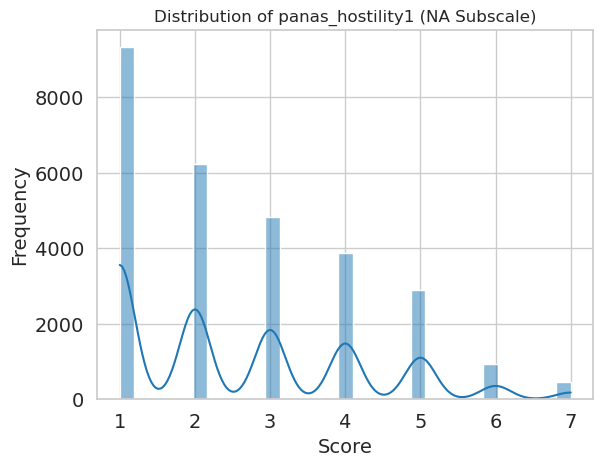

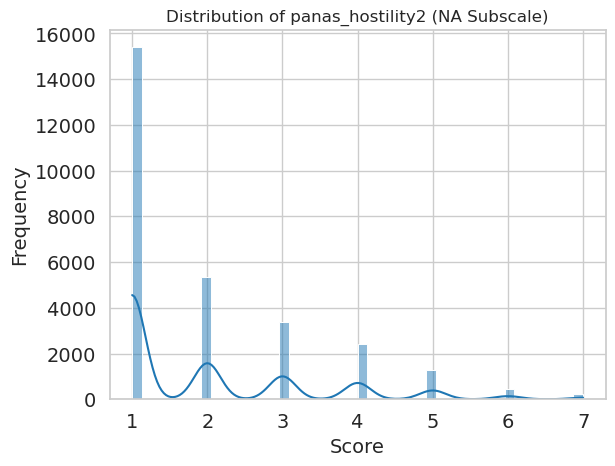

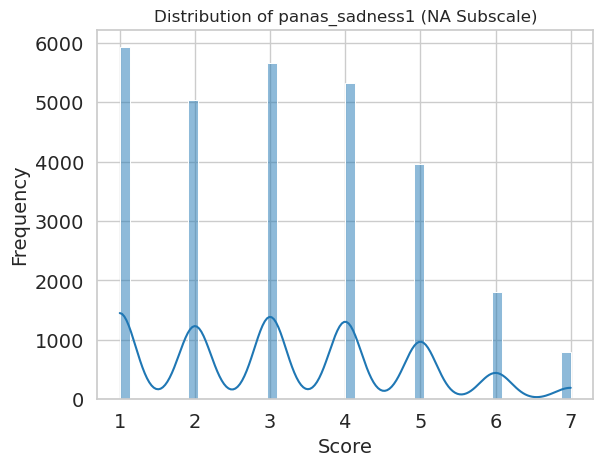

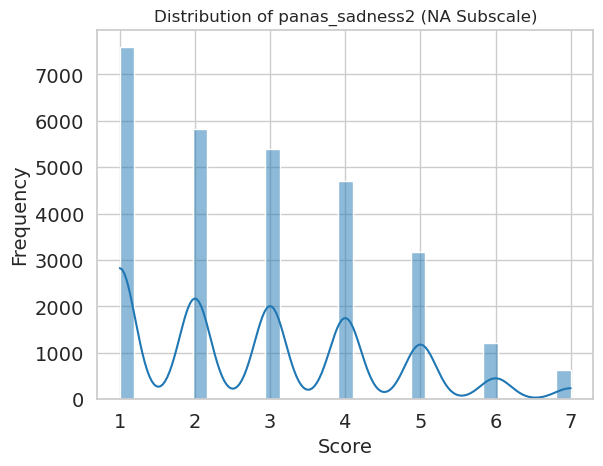

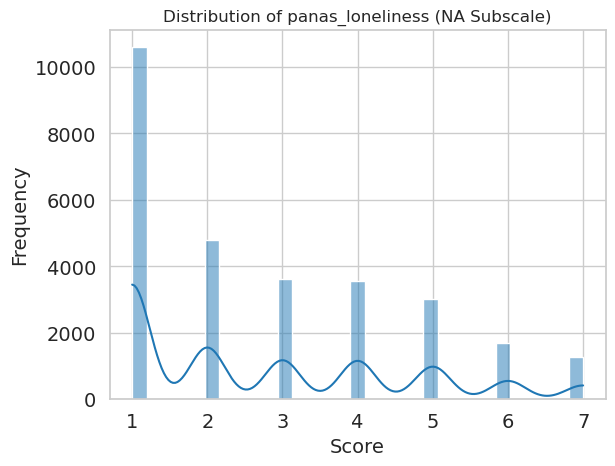

In [23]:


na_scale = ['panas_fear1', 'panas_fear2', 'panas_guilt1', 
            'panas_guilt2', 'panas_hostility1', 'panas_hostility2', 
            'panas_sadness1', 'panas_sadness2', 'panas_loneliness']


# NA subscale plots
for subscale in na_scale:
    sns.histplot(df_piv[subscale], kde=True)
    plt.title(f'Distribution of {subscale} (NA Subscale)')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()


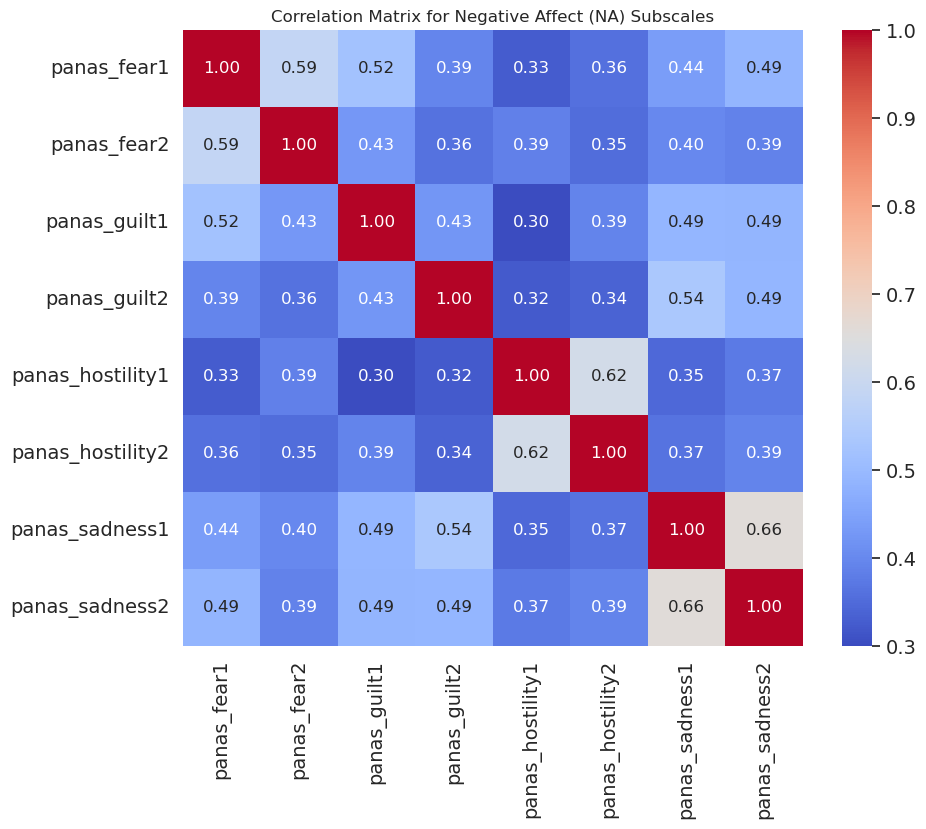

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the NA subscales
na_scale = ['panas_fear1', 'panas_fear2', 'panas_guilt1', 
            'panas_guilt2', 'panas_hostility1', 'panas_hostility2', 
            'panas_sadness1', 'panas_sadness2']

# Calculate the correlation matrix for NA subscales
correlation_matrix = df_piv[na_scale].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Negative Affect (NA) Subscales")
plt.show()


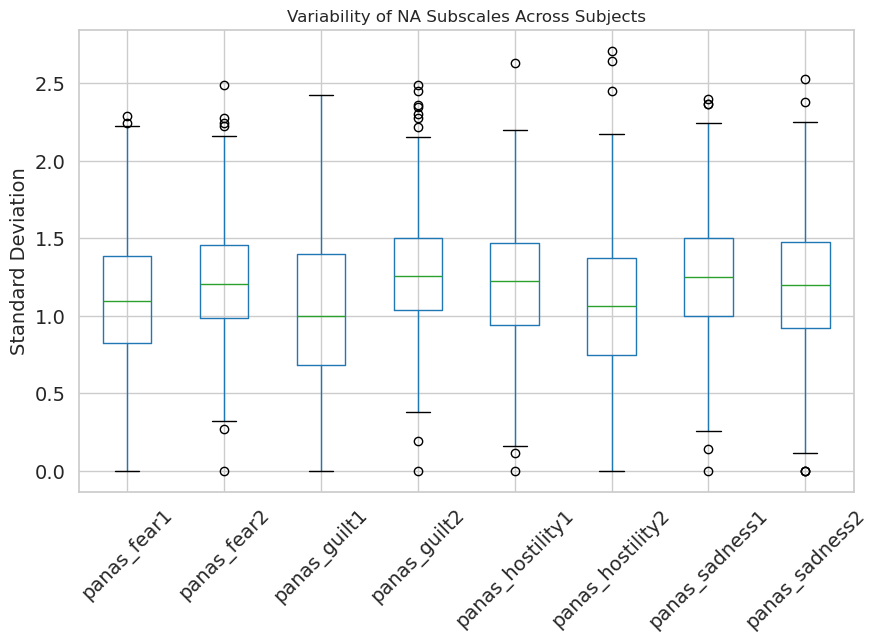

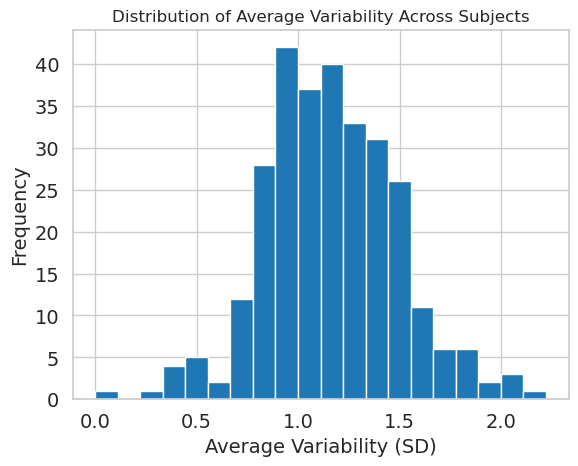

In [25]:
# Calculate variability (e.g., standard deviation) for each subject
subject_variability = df_piv.groupby('customer')[na_scale].std()

# Plot a boxplot of variability across subjects
subject_variability.boxplot(figsize=(10, 6))
plt.title('Variability of NA Subscales Across Subjects')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

# Alternatively, use a histogram for distribution of overall variability
subject_variability.mean(axis=1).hist(bins=20)
plt.title('Distribution of Average Variability Across Subjects')
plt.xlabel('Average Variability (SD)')
plt.ylabel('Frequency')
plt.show()


In [26]:
# Keep only customers with complete assessment
df_piv_merged = df_piv.merge(df_sit, on=["customer", "unique_day_id"], how="right")

# Keep only customers with complete assessment
df_piv_merged = df_piv_merged.merge(df_social, on=["customer", "unique_day_id"], how="right")

In [27]:
# Define the situation mapping
situation_mapping = {
    'Etwas Anderes': 'other',  
    'Kümmern um Kinder / Angehörige': 'care work',
    'Unterwegs (z.B. in der U-Bahn)': 'travelling',
    'Hausarbeit oder Erledigungen': 'chores',
    'Essen/ Trinken/ Körperpflege': 'eating - drinking - selfcare',  # Changed commas to hyphens
    'Freizeitaktivität, eher aktiv (z.B. Sport, Unternehmungen)': 'active leisure',
    'Smartphone/ Soziale Medien': 'smartphone - social media',  # Changed commas to hyphens
    'Freizeitaktivität, eher passiv (z.B. Film schauen, Lesen)': 'passive leisure',
    'Arbeit oder Studium': 'work or study'
}

# Apply the mapping to the 'situation1' column
df_piv_merged['situation1_simplified'] = df_piv_merged['situation1'].map(situation_mapping)

In [28]:
# Keep only first assessment phase
df_piv_merged = df_piv_merged.loc[df_piv_merged.assess.isin(assessment_phase)]

# keep inly customers with engough data in first assessment phase
df_piv_merged = df_piv_merged.loc[df_piv_merged.customer.isin(df_ema1_customers)]
df_piv_merged = df_piv_merged.drop_duplicates()

### 3. Create binary negative affect score

In [29]:

# Step 1: Calculate the mode of 'mean_pa' and 'mean_na' for each customer
def calculate_customer_modes(df):
    # Group by customer and apply mode calculation
    modes = df.groupby('customer').agg({
        'mean_pa': lambda x: x.mode()[0] if not x.mode().empty else None,  # Mode for mean_pa
        'mean_na': lambda x: x.mode()[0] if not x.mode().empty else None   # Mode for mean_na
    })
    return modes

# Step 2: Add the mode values as new columns to the original dataframe
modes = calculate_customer_modes(df_piv_merged)

# Merge the mode values back to the original dataframe
df_piv_merged = df_piv_merged.merge(modes, on='customer', suffixes=('', '_mode'))

# Step 3: Create new columns for the binary classification based on mode comparison
def label_rows(df):
    # Label 'mean_pa' as 1 if above mode, otherwise 0
    df['mean_pa_label'] = (df['mean_pa'] < df['mean_pa_mode']).astype(int)
    
    # Label 'mean_na' as 1 if below mode (improvement), otherwise 0
    df['mean_na_label'] = (df['mean_na'] > df['mean_na_mode']).astype(int)
    
    return df

# Apply the labeling function
df_piv_merged = label_rows(df_piv_merged)


In [30]:
df_piv_merged.groupby("mean_na_label")["customer"].count()

mean_na_label
0    20699
1    19971
Name: customer, dtype: int64

## 5. Match with Redcap data

In [31]:
df_redcap_full = pd.merge(df_redcap, df_piv_merged, on= "customer", how="right")

In [32]:
df_piv_merged.groupby("customer")["unique_day_id"].nunique().sum()

np.int64(12691)

In [33]:
df_piv_merged.groupby("customer")["unique_day_id"].nunique().mean()

np.float64(63.455)

In [34]:
df_piv_merged.groupby("customer")["unique_day_id"].nunique().std()

np.float64(22.18374557731845)

#### 5.1 Situation distribution across categories

In [35]:
df_redcap_age = df_redcap_full.loc[df_redcap_full.age >18][["customer", "age"]].drop_duplicates()

## 6. Match with Passive data 

In [36]:
df_final = df_ema_passive.merge(df_redcap_full, on=["customer", "unique_day_id", "assess"], how="right")

In [37]:
df_final['quest_hour'] = df_final['sensor_block_end'].dt.hour
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 14:
        return 'noon'
    elif 14 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

df_final['time_of_day'] = df_final['quest_hour'].apply(categorize_time_of_day)


In [38]:

def categorize_season(date):
    if pd.isna(date):  # Check if the value is NaT
        return None  # Return None (or you can choose another label like 'Unknown')

    day_of_year = date.timetuple().tm_yday

    if 80 <= day_of_year < 172:
        return 'spring'
    elif 172 <= day_of_year < 264:
        return 'summer'
    elif 264 <= day_of_year < 355:
        return 'autumn'
    else:
        return 'winter'

df_final['season'] = df_final['sensor_block_end'].apply(categorize_season)


In [39]:
 df_final_red_red = df_final.loc[df_final.at_home_binary !=-1]

In [40]:
aggregated_df = aggregated_df.loc[aggregated_df.at_home_binary != -1]

NameError: name 'aggregated_df' is not defined

In [ ]:
aggregated_df = aggregated_df.loc[aggregated_df.at_home_binary != -1]